In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt 
import scipy.integrate as spint

import scipy.optimize as spopt
import numpy as np
import tqdm.notebook
from jax import config
config.update('jax_enable_x64', True)
import time

In [2]:
sigma = 1.
B = np.diag(np.array([-1e-2, -1e-2, -0.01, -0.05]))
U = []
def rhs_linear_control(x, t):
    return jnp.array([x[1], -x[0] * (1 + x[2]**2), x[3], -x[2] * (1 + x[0]**2)]) + B @ x


rhs = rhs_linear_control
x0 = jnp.hstack((jnp.array([1, 0]), sigma * jax.random.normal(jax.random.PRNGKey(1), (2,))))
print(x0)

[ 1.          0.          0.17269028 -0.46084179]


In [3]:
delta_t = 1e-1
final_T = 50
num_T = 500
t_range = jnp.linspace(0, final_T, num=num_T+1)
print(t_range, t_range.shape)
traj = spint.odeint(rhs, x0, t_range)

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3
 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1
 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5
 19.6 

In [4]:
traj

array([[ 1.        ,  0.        ,  0.17269028, -0.46084179],
       [ 0.99388608, -0.10196508,  0.12500622, -0.48821873],
       [ 0.97770412, -0.20148801,  0.07513369, -0.5055193 ],
       ...,
       [ 0.62223227,  0.00136219,  0.05521164, -0.06465977],
       [ 0.61863202, -0.06087018,  0.04834335, -0.07150122],
       [ 0.60884891, -0.12232645,  0.04085043, -0.0772785 ]])

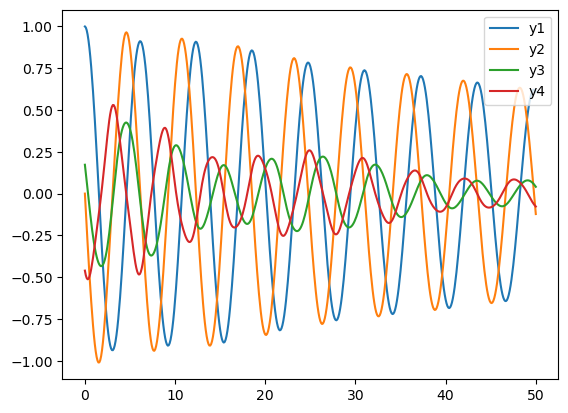

In [5]:
plt.plot(t_range, traj[:, 0], label="y1")
plt.plot(t_range, traj[:, 1], label="y2")
plt.plot(t_range, traj[:, 2], label="y3")
plt.plot(t_range, traj[:, 3], label="y4")
plt.legend()

In [6]:
input_hist_array = traj.T
input_hist_array.shape

(4, 501)

In [7]:
import time
N = int(1e2)

total_history = np.zeros((num_T + 1, 2, int(N)))
total_history_control = np.zeros((num_T + 1, 2, int(N)))
key = jax.random.PRNGKey(1)
st = time.time()
for i in tqdm.notebook.tqdm(range(N)):
    key, subkey = jax.random.split(key, 2)
    cur_x0 = jnp.hstack((jnp.array([1, 0]), sigma * jax.random.normal(subkey, (2,))))
    current_traj = spint.odeint(rhs, cur_x0, t_range)
    total_history[:, :, i] = current_traj[:, :2]
print("MC averaging timing = {}".format(time.time() - st))

  0%|          | 0/100 [00:00<?, ?it/s]

MC averaging timing = 11.451269149780273


In [8]:
proj_total_hist = np.mean(total_history, axis=2)
std_proj_total_hist = np.std(total_history, axis=2)

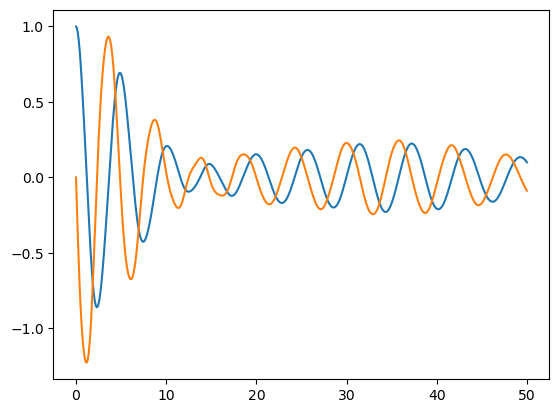

In [9]:
plt.plot(t_range, proj_total_hist[:, 0])
plt.plot(t_range, proj_total_hist[:, 1])

In [10]:
Gp = traj[1:, :2].T
Gm = traj[:-1, :2].T

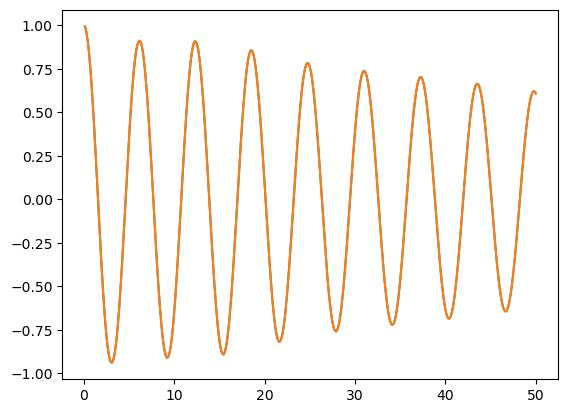

In [11]:
plt.plot(t_range[1:], Gp[0, :])
plt.plot(t_range[1:], traj[1:, 0])

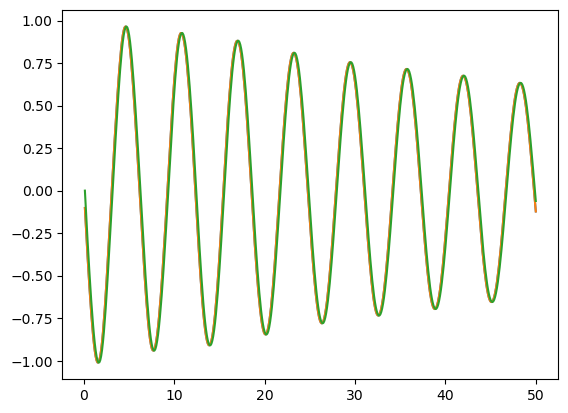

In [12]:
plt.plot(t_range[1:], Gp[1, :])
plt.plot(t_range[1:], traj[1:, 1])
plt.plot(t_range[1:], input_hist_array[1, :-1])

In [13]:
print(Gm.shape, input_hist_array.shape, Gp.shape)
dmd_result = Gp @ np.linalg.pinv(np.vstack(Gm))

(2, 500) (4, 501) (2, 500)


In [14]:
dmd_result.shape, dmd_result

((2, 2),
 array([[ 0.9938988 ,  0.09973455],
        [-0.10194705,  0.99398948]]))

In [15]:
A_dmd = dmd_result[:, :2]
B_dmd = dmd_result[:, 2:]

In [16]:
A_dmd, B_dmd

(array([[ 0.9938988 ,  0.09973455],
        [-0.10194705,  0.99398948]]),
 array([], shape=(2, 0), dtype=float64))

In [17]:
# Extract spectrum of A_dmd and resonstruct trajectory from it
eigval_dmd, eigvec_dmd = np.linalg.eig(A_dmd)

def get_prediction_with_control(A, x0, t_range, control):
    prediction = np.zeros((x0.shape[0], len(t_range)))
    prediction[:, 0] = x0.copy()
    for i in range(1, len(t_range)):
        prediction[:, i] = A @ prediction[:, i-1]
    return prediction 
dmd_pred_traj = get_prediction_with_control(A_dmd, x0[:2], t_range, input_hist_array)

In [18]:
dmd_pred_traj.shape,t_range.shape,eigval_dmd, abs(eigval_dmd)

((2, 501),
 (501,),
 array([0.99394414+0.10083472j, 0.99394414-0.10083472j]),
 array([0.99904584, 0.99904584]))

Text(0, 0.5, '$y_1$')

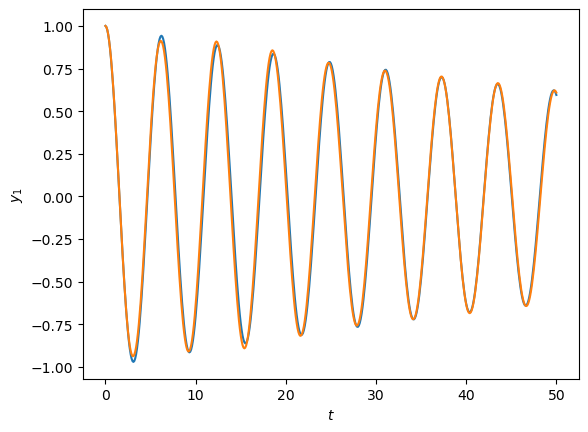

In [19]:
plt.plot(t_range, dmd_pred_traj[0, :].real)
plt.plot(t_range, traj[:, 0], label="y1")
plt.xlabel("$t$")
plt.ylabel("$y_1$")

Text(0, 0.5, '$y_2$')

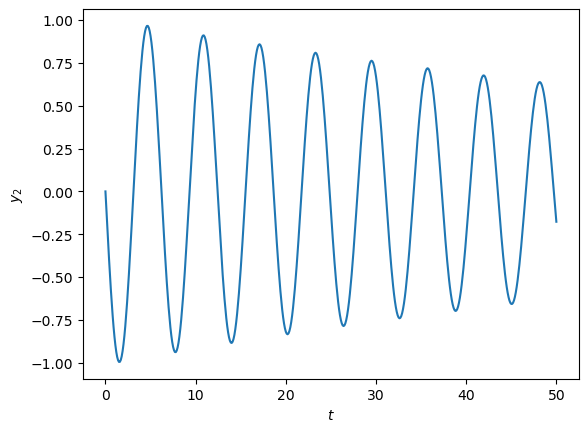

In [20]:
plt.plot(t_range, dmd_pred_traj[1, :].real)
plt.xlabel("$t$")
plt.ylabel("$y_2$")

In [21]:
# Function to generate trajectory for MZDMD approach
def generate_traj_mzdmd(A, B, t_range, x0, K0):
    n = x0.shape[0]
    I = jnp.eye(n)
    M = I - 2 * (A - I) @ jnp.linalg.inv(A + I)
    traj = np.zeros((x0.shape[0], t_range.shape[0]))
    traj[:, 0] = x0.copy()
    for i in range(1, t_range.shape[0]):
        x_next = A @ traj[:, i-1] + B @ traj[:, i-1] * delta_t
        correction = jnp.mean(jnp.linalg.inv(A - I) @ jsp.linalg.expm((i-1) * (A - I)) @ (jnp.linalg.matrix_power(M, i-1) - I) @ K0, axis=1)
        x_next -= delta_t**2 * correction 
        traj[:, i] = x_next.copy()
    return traj

In [22]:
def compute_M(A):
    n = A.shape[0]
    I = jnp.eye(n)
    M = I - 2 * (A - I) @  jnp.linalg.inv(A + I)
    return M

def body_fun(carry, x):
    K0, cur_matrix_exp, matrix_exp, cur_M_power, M, I = carry
    y = cur_matrix_exp @ (cur_M_power - I) @ K0
    y_mean = jnp.mean(y, axis=1)
    carry = (K0, cur_matrix_exp @ matrix_exp, matrix_exp, cur_M_power @ M, M, I)
    return carry, y_mean


def compute_f_scan(A, K0, num_cols, delta_t, num_rows):
    F = jnp.zeros((num_rows, num_cols))
    I = jnp.eye(num_rows)
    M = compute_M(A)
    matrix_exp = jsp.linalg.expm(A - I)
    _, Fpart = jax.lax.scan(body_fun, (K0, matrix_exp, matrix_exp, M, M, I), jnp.arange(1, num_cols))
    F = F.at[:, 1:].set(Fpart.T)
    return F

from functools import partial

@partial(jax.jit, static_argnums=(3, 4))
def compute_M_tilde(A, delta_t, K0, num_cols, num_rows):
    I = jnp.eye(num_rows)
    factor_matrix = jnp.linalg.inv(A - I)
    estimated_snapshots = compute_f_scan(A, K0, num_cols, delta_t, num_rows)
    M_tilde = factor_matrix @ estimated_snapshots
    return M_tilde 

In [23]:
@jax.jit 
def objective(A, B, Gp, Gm, delta_t, K0):
    M = compute_M_tilde(A, delta_t, K0, Gp.shape[1], Gp.shape[0])
    residual = Gp - A @ Gm + delta_t**2 * M - B @ Gm
    return jnp.sum(residual**2)

In [28]:
import optax
learning_rate = 1e-3
adam_optimizer = optax.adam(learning_rate)

def proxy_obj(mat, K0):
    A_pert = mat[0]
    B = mat[1]
    A = A_dmd + delta_t * A_pert
    return objective(A, B, Gp, Gm, delta_t, K0)

@jax.jit
def step_optax(params, opt_state, K0):
    loss_value, grads = jax.value_and_grad(proxy_obj)(params, K0)
    updates, opt_state = adam_optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

In [29]:
# Initialization of optimizer
opt_state = adam_optimizer.init((jnp.zeros((2,2)), 
                                 jnp.zeros((2,2))))
# Initialization of hidden parts of the dynamics
K0 = sigma * jax.random.normal(jax.random.PRNGKey(10), (2, 1))
K0 /= jnp.linalg.norm(K0)
print(jnp.linalg.norm(K0))

0.9999999999999999


In [30]:
params = jnp.zeros((2,2)), jnp.zeros((2,2))
loss_hist = []
proxy_obj(params, K0)

Array(5.61705875, dtype=float64)

In [31]:
num_internal_adam_iter = 100
start = time.time()
for i in range(num_internal_adam_iter):
    params, opt_state, loss_value = step_optax(params, opt_state, K0)
    print("Iteration = {}, loss = {}".format(i, loss_value))
    loss_hist.append(loss_value)
A_mzdmd = A_dmd + delta_t * params[0].copy()
B_mzdmd = params[1].copy()
rand_part = np.random.randn(2, 1000)
mz_dmd_traj = generate_traj_mzdmd(A_mzdmd, B_mzdmd, t_range, x0[:2], rand_part)
fin = time.time()
print("OPc runtime =", fin - start)
print(jnp.linalg.eigvals(A_mzdmd))
print(B_mzdmd)

Iteration = 0, loss = 5.6170587497172635
Iteration = 1, loss = 5.55105856837497
Iteration = 2, loss = 5.4884935988135
Iteration = 3, loss = 5.429374009738222
Iteration = 4, loss = 5.373692499251284
Iteration = 5, loss = 5.321422832218582
Iteration = 6, loss = 5.272518427263715
Iteration = 7, loss = 5.226911110032642
Iteration = 8, loss = 5.184510196906228
Iteration = 9, loss = 5.145202115404613
Iteration = 10, loss = 5.108850785507233
Iteration = 11, loss = 5.075298956977052
Iteration = 12, loss = 5.044370604674342
Iteration = 13, loss = 5.015874331647389
Iteration = 14, loss = 4.9896075556231985
Iteration = 15, loss = 4.965361119735296
Iteration = 16, loss = 4.942923927537299
Iteration = 17, loss = 4.922087268361112
Iteration = 18, loss = 4.902648632337507
Iteration = 19, loss = 4.884414948690832
Iteration = 20, loss = 4.867205264666942
Iteration = 21, loss = 4.850852903122673
Iteration = 22, loss = 4.835207116136367
Iteration = 23, loss = 4.820134223266349
Iteration = 24, loss = 4.80

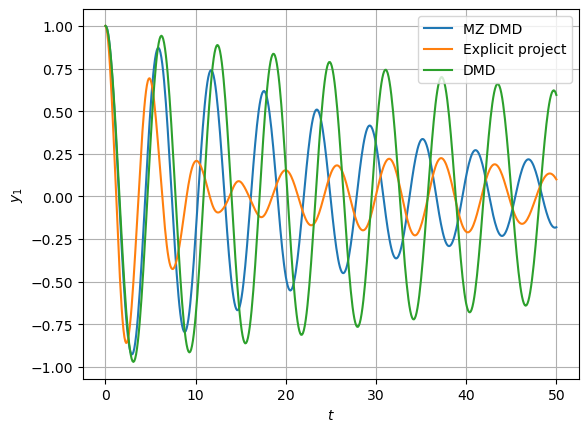

In [32]:
plt.plot(t_range, mz_dmd_traj[0], label="MZ DMD")
plt.plot(t_range, proj_total_hist[:, 0], label="Explicit project")
plt.plot(t_range, dmd_pred_traj[0, :].real, label="DMD")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$y_1$")
plt.grid()

In [35]:
num_samples_for_std = 100
mz_dmd_traj = np.zeros((num_samples_for_std, 2, t_range.shape[0]))
gen = np.random.default_rng(42)
for i in range(num_samples_for_std):
    rand_part = gen.standard_normal((2, 10000)) * np.sqrt(sigma)
    mz_dmd_traj[i] = generate_traj_mzdmd(A_mzdmd, B_mzdmd, t_range, x0[:2], rand_part)

In [36]:
np.std(mz_dmd_traj, axis=0).mean(axis=1)

array([0.04538998, 0.04657653])